In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import time
from sklearn import datasets, linear_model
from sklearn import cross_validation, metrics
from nltk.corpus import stopwords
import timeit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from nltk import ngrams
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk import stem
%matplotlib inline
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
#Run Attributes
maxGram=2

In [3]:
just_train = True

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')
train=train.fillna('')
test=test.fillna('')

In [5]:
train['isTrain']=train.apply(lambda row: 1, axis=1)
test['isTrain']=test.apply(lambda row: 0, axis=1)

In [6]:
stops=stopwords.words("english")+['']
strPunc=string.punctuation + '“”'

In [48]:
a = "this is a test"
[st.stem(x) for x in a.split()]

['thi', 'is', 'a', 'test']

In [44]:
st = stem.LancasterStemmer()
def puncRepl(c):
    if c in '-_':
        return ''
    elif c in strPunc:
        return ' '
    else:
        return c
def cleanQ(Q):
    Q = Q.lower()
    Q = ''.join([puncRepl(x) for x in Q]) #change this to RE with punc followed by whitespace
    Q = [x for x in Q.split(' ') if x not in ''] #if x not in stops]
    Q = ' '.join(Q)
    return Q

In [9]:
#######Setup Train Qs#######
start = time.time()
if just_train:
    TT = train
else:
    TT=train.append(test)
TT=TT.reset_index(drop=True)

TT['question1C']=TT.apply(lambda row: cleanQ(row['question1']),axis=1)
TT['question2C']=TT.apply(lambda row: cleanQ(row['question2']),axis=1)
train_qs = pd.Series(TT['question1C'].tolist() + TT['question2C'].tolist()).astype(str)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

0 Minute(s), 35 Second(s).


In [11]:
train_qs.head()

0    what is the step by step guide to invest in sh...
1       what is the story of kohinoor kohinoor diamond
2    how can i increase the speed of my internet co...
3     why am i mentally very lonely how can i solve it
4    which one dissolve in water quikly sugar salt ...
dtype: object

In [12]:
qt="hard to parse/understand sentence. And  'another' one"
cleanQ(qt)

'hard to parse understand sentence and another one'

In [13]:
start = time.time()

counter=0
nDocsDict = {}
for i in range(1,maxGram+1):
    nDocsDict[i]={}
for row in train_qs:
    phraseList=[]
    question = row
    question=question.split()
    for i in range(1,maxGram+1):
        for count in range(0,len(question)-(i-1)):
            phrase = ' '.join(question[count:count+i])
            if phrase not in phraseList:
                if phrase in nDocsDict[i]:
                    nDocsDict[i][phrase] = nDocsDict[i][phrase] + 1
                else:
                    nDocsDict[i][phrase] = 1
                phraseList = phraseList+[phrase]

                
                
#print(counter)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

0 Minute(s), 33 Second(s).


In [14]:
nDocs=train_qs.shape[0]

In [15]:
weights={}
for i in range(1,maxGram+1):
    weights[i] = dict((k, np.log(nDocs/(1+v))) for k, v in nDocsDict[i].items() if v>1)

In [17]:
nDocsDict={}

In [18]:
def genGramTFIDF(a,b,g=1): #WIP
    a,b=a.split(),b.split()
    
    a=[' '.join(a[i:i+g]) for i in range(len(a)-g+1)]
    b=[' '.join(b[i:i+g]) for i in range(len(b)-g+1)]
    
    num=np.sum([b.count(x)*weights[g].get(x,0)**2 for x in a if x in b])
    au = list(set(a))
    bu = list(set(b))
    den1=np.linalg.norm(np.array([a.count(x)*weights[g].get(x,0) for x in au]))
    den2=np.linalg.norm(np.array([b.count(x)*weights[g].get(x,0) for x in bu]))
    den = (den1*den2)
    
    wordShare=np.sum([b.count(x)*1 for x in a if x not in stops])
    len1=np.sum([1 for x in a if x not in stops])
    len2=np.sum([1 for x in b if x not in stops])
    unW1=np.sum([1 for x in au])
    unW2=np.sum([1 for x in bu])
    
    return num,den,num/den,den1/(den2+0.00000001),wordShare,len1/(len2+0.000000001),\
           len1+len2,unW1/(unW2+0.00000001), wordShare/np.mean([len1,len2])

In [19]:
genGramTFIDF("one two two","one two")

(71.236571031366552,
 74.006028599654741,
 0.96257794640934013,
 1.734988337597841,
 3,
 1.4999999992499999,
 5,
 2,
 2,
 1.2)

In [20]:
genGramTFIDF(TT.loc[0,'question1'],TT.loc[0,'question2'])

(378.54997194729992,
 396.11546717804299,
 0.95565561891364403,
 1.0527222768105611,
 8,
 1.1428571426938776,
 15,
 12,
 11,
 1.0666666666666667)

In [21]:
start = time.time()
for i in range(1,maxGram+1):
    (TT['GIDFNum'+str(i)],
     TT['GIDFDen'+str(i)],
     TT['GIDF'+str(i)],
     TT['GIDFDenDiff'+str(i)],
     TT['WordShare'+str(i)],
     TT['LenDiff'+str(i)],
     TT['LenTot'+str(i)],
     TT['unW1'+str(i)],
     TT['unW2'+str(i)],
     TT['WSpct'+str(i)],
    )= \
    zip(*TT.apply(lambda row: genGramTFIDF(row['question1C'],row['question2C'],i),axis=1))
    print(i)
duration = time.time() - start
print(str(int(duration//60)) + " Minute(s), " + str(int(duration%60)) + " Second(s).")

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in double_scalars


1
2
5 Minute(s), 13 Second(s).


In [22]:
target='is_duplicate'
predictors = [x for x in list(TT) if x not in ['id','qid1','qid2','question1','question2','is_duplicate','rdSimPct', 
                                                  'preds', 'question1C','question2C', 'test_id', 'isTrain']]

In [23]:
TT[predictors+['question1C','question2C']]

,GIDFNum1,GIDFDen1,GIDF1,GIDFDenDiff1,WordShare1,LenDiff1,LenTot1,unW11,unW21,WSpct1,...,GIDF2,GIDFDenDiff2,WordShare2,LenDiff2,LenTot2,unW12,unW22,WSpct2,question1C,question2C
0,413.339988,419.969956,0.984213,1.021657,8.0,1.166667,13.0,12.0,11.0,1.230769,...,0.940709,1.063028,11.0,1.181818,24.0,13.0,11.0,0.916667,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,516.583044,643.870299,0.802309,0.866469,5.0,0.444444,13.0,7.0,11.0,0.769231,...,0.344569,0.729519,2.0,0.583333,19.0,7.0,12.0,0.210526,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...
2,75.310247,316.651774,0.237833,0.914674,2.0,1.200000,11.0,14.0,10.0,0.363636,...,0.009724,0.860749,1.0,1.444444,22.0,13.0,9.0,0.090909,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,0.000000,428.956938,0.000000,0.566691,0.0,0.333333,12.0,10.0,10.0,0.000000,...,0.000000,0.791394,0.0,0.833333,22.0,10.0,12.0,0.000000,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...
4,98.980061,407.097475,0.243136,1.863648,2.0,2.000000,15.0,13.0,7.0,0.266667,...,0.000000,1.634648,0.0,2.000000,18.0,12.0,6.0,0.000000,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water
5,363.194560,760.206076,0.477758,0.977608,5.0,1.000000,16.0,16.0,16.0,0.625000,...,0.328472,0.908493,5.0,1.000000,32.0,16.0,16.0,0.312500,astrology i am a capricorn sun cap moon and ca...,i m a triple capricorn sun moon and ascendant ...
6,0.000000,221.600400,0.000000,0.804860,0.0,0.285714,9.0,4.0,10.0,0.000000,...,0.000000,0.238775,0.0,0.300000,13.0,3.0,10.0,0.000000,should i buy tiago,what keeps childern active and far from phone ...
7,149.172944,181.335903,0.822633,0.920588,1.0,1.000000,4.0,7.0,9.0,0.500000,...,0.207282,0.741499,1.0,0.750000,14.0,6.0,8.0,0.142857,how can i be a good geologist,what should i do to be a great geologist
8,76.836146,176.995505,0.434114,2.200945,2.0,2.000000,6.0,8.0,7.0,0.666667,...,0.325303,1.337661,4.0,1.166667,13.0,7.0,6.0,0.615385,when do you use シ instead of し,when do you use instead of and
9,280.555867,377.134420,0.743915,1.084561,3.0,1.200000,11.0,9.0,9.0,0.545455,...,0.207482,1.078666,1.0,1.000000,16.0,8.0,8.0,0.125000,motorola company can i hack my charter motorol...,how do i hack motorola dcx3400 for free internet


In [24]:
TT[TT['isTrain']==1]

,id,qid1,qid2,question1,question2,is_duplicate,isTrain,question1C,question2C,GIDFNum1,...,GIDFNum2,GIDFDen2,GIDF2,GIDFDenDiff2,WordShare2,LenDiff2,LenTot2,unW12,unW22,WSpct2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,413.339988,...,734.687064,780.992631,0.940709,1.063028,11.0,1.181818,24.0,13.0,11.0,0.916667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,516.583044,...,253.187122,734.793625,0.344569,0.729519,2.0,0.583333,19.0,7.0,12.0,0.210526
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,75.310247,...,7.231121,743.623788,0.009724,0.860749,1.0,1.444444,22.0,13.0,9.0,0.090909
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0.000000,...,0.000000,773.096860,0.000000,0.791394,0.0,0.833333,22.0,10.0,12.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,98.980061,...,0.000000,926.598721,0.000000,1.634648,0.0,2.000000,18.0,12.0,6.0,0.000000
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,1,astrology i am a capricorn sun cap moon and ca...,i m a triple capricorn sun moon and ascendant ...,363.194560,...,380.706100,1159.022427,0.328472,0.908493,5.0,1.000000,32.0,16.0,16.0,0.312500
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,1,should i buy tiago,what keeps childern active and far from phone ...,0.000000,...,0.000000,189.732588,0.000000,0.238775,0.0,0.300000,13.0,3.0,10.0,0.000000
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,1,how can i be a good geologist,what should i do to be a great geologist,149.172944,...,26.774978,129.171452,0.207282,0.741499,1.0,0.750000,14.0,6.0,8.0,0.142857
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,1,when do you use シ instead of し,when do you use instead of and,76.836146,...,150.730678,463.355271,0.325303,1.337661,4.0,1.166667,13.0,7.0,6.0,0.615385
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,1,motorola company can i hack my charter motorol...,how do i hack motorola dcx3400 for free internet,280.555867,...,44.341584,213.712794,0.207482,1.078666,1.0,1.000000,16.0,8.0,8.0,0.125000


In [27]:
selectTrain=TT['isTrain']==1
selectTest=TT['isTrain']==0

x_train=TT[selectTrain][predictors]
y_train=TT[selectTrain]['is_duplicate'].values

pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

if not just_train:
    x_test=TT[selectTest][predictors]
    x_test_ids=TT[selectTest]['test_id']

# # Now we oversample the negative class
# # There is likely a much more elegant way to do this...
# p = 0.165
# scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
# while scale > 1:
#     neg_train = pd.concat([neg_train, neg_train])
#     scale -=1
# neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
# print(len(pos_train) / (len(pos_train) + len(neg_train)))

# x_train = pd.concat([pos_train, neg_train])
# y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
# del pos_train, neg_train

In [28]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split

# TT[predictors]=TT[predictors].fillna(0)

# scaler = MinMaxScaler().fit(TT[predictors])

# X = pd.DataFrame(scaler.transform(TT[selectTrain][predictors]),columns=predictors)
# y = TT[selectTrain]['is_duplicate']

# x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

In [29]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.33, random_state=4242)

In [30]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.1
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

watchlist = [(d_train, 'train')]#, (d_valid, 'valid')]

bst = xgb.train(params, d_train, 300, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.666348
Will train until train-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.544341
[20]	train-logloss:0.508004
[30]	train-logloss:0.493802
[40]	train-logloss:0.486128
[50]	train-logloss:0.479994
[60]	train-logloss:0.474899
[70]	train-logloss:0.47081
[80]	train-logloss:0.467625
[90]	train-logloss:0.464876
[100]	train-logloss:0.462647
[110]	train-logloss:0.460641
[120]	train-logloss:0.458579
[130]	train-logloss:0.456791
[140]	train-logloss:0.455442
[150]	train-logloss:0.453999
[160]	train-logloss:0.452794
[170]	train-logloss:0.451379
[180]	train-logloss:0.450306
[190]	train-logloss:0.449574
[200]	train-logloss:0.448623
[210]	train-logloss:0.447647
[220]	train-logloss:0.44675
[230]	train-logloss:0.44598
[240]	train-logloss:0.445156
[250]	train-logloss:0.444442
[260]	train-logloss:0.443791
[270]	train-logloss:0.442881
[280]	train-logloss:0.442256
[290]	train-logloss:0.441578


In [31]:
metrics.log_loss(y_valid, bst.predict(d_valid))

0.4513380746112754

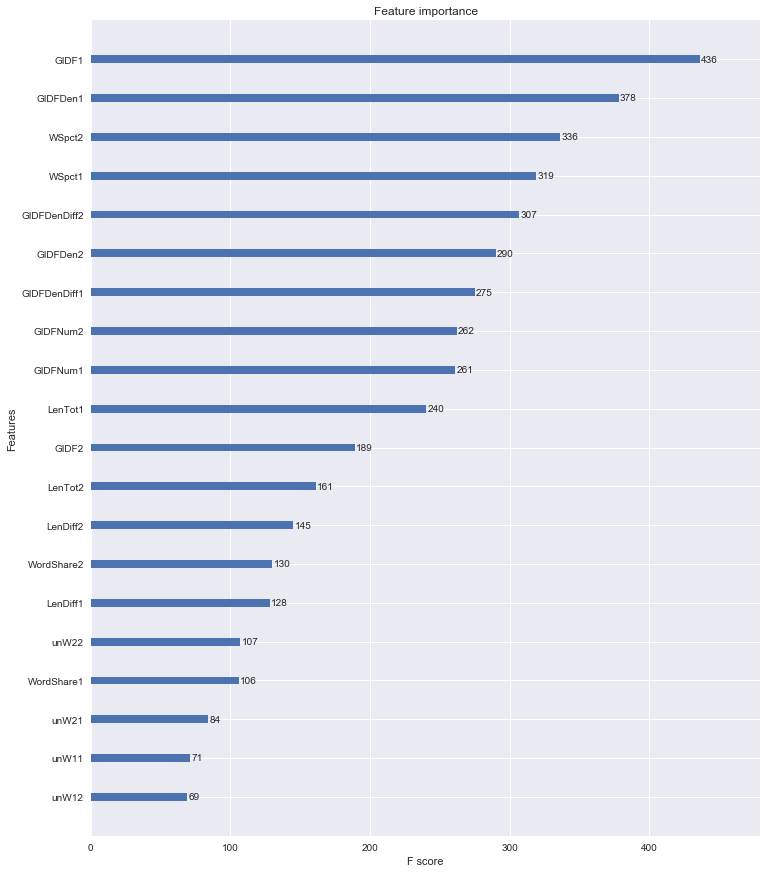

In [32]:
plt.rcParams['figure.figsize'] = (12.0, 15.0)
xgb.plot_importance(bst); plt.show()

In [ ]:
submit=pd.DataFrame()
submit['test_id']=x_test_ids
submit['is_duplicate']=bst.predict(d_test)

In [ ]:
submit['test_id']=submit.apply(lambda row: int(row['test_id']),axis=1)

In [ ]:
submit

In [ ]:
submit.to_csv('../output/submission169Rel_2Gs_valid.csv',index=False)

In [ ]:
#1TFIDF .517835
#Adding num and den: 0.513763
#log->v+10k: 0.500909
#Back to Log, normalized nums: 0.501241 +RF ->0.499851
#making / spaces etc: XXXXXXXXXX
#putting stopwords back in: 0.521442
#Real TFIDF: 0.513535
#Real TFIDF w/testQs: 0.513451



#TFIDF on 5: 0.418284
#Real TFIDF on 5: ~0.407

In [ ]:
#NV#
notafunc

In [ ]:
d_train = xgb.DMatrix(X, label=y_train)
train['preds']=bst.predict(d_train)

In [ ]:
sns.distplot(train.preds[0:2000])

In [ ]:
x_train

In [ ]:
x_train['xgbPreds']=train['preds']

In [ ]:
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_valid)

NV=pd.DataFrame()
NV['preds']=y_pred
NV['valid']=y_valid.values

In [ ]:
print("LogLoss Score (Train): %f" % metrics.log_loss(NV['valid'],NV['preds'].values))

In [ ]:
sns.distplot(NV.preds[0:2000])